# About this notebook
Implement of [Gozsoy's Conditionval VAE code(github)](https://github.com/gozsoy/conditional-vae).
Originaly I imported [Elmisis's VAE code(github)](https://github.com/EleMisi/ConditionalVAE/) to make this [example](https://github.com/chhyyi/rz_cvae) but loss diverges. Also input of attributes(or conditioned input) are not efficient so I found another codes.   

As team decided not to solve this problem cuz deadline of Aiffelthon is DEC 13, there will be no discussion about diverging loss.  

I'll change only some lines of [cvae_example](https://github.com/chhyyi/rz_cvae/blob/main/cvae_expamle.ipynb) and python scripts (actually many part of gozsoy's code is hard coded but I'm not gonna fix that)

# Some test
1. input parameter of conditional_encoder2 is hard-coded. So I'd better test this one.
2. I think this is  all I need then   

```python  
if __name__ == '__main__':

    beta = 1e-11
    epochs = 10
    latent_dim = 15

    train_ds,dataset_mean,dataset_std = prepare_data()

    model,z_mu_list,label_list = train(latent_dim,beta,epochs,train_ds,dataset_mean,dataset_std)
```

In [1]:
import gozsoy_src.model as gmodel
import gozsoy_src.main as gmain
import gozsoy_src.utils as gutils

import tensorflow as tf

# copy of cvae_example

In [25]:
# load dataset
import pandas as pd
list_attr_path = "list_attr.csv"

In [26]:
import gozsoy_src.model as gmodel
import gozsoy_src.main as gmain
import gozsoy_src.utils as gutils

import tensorflow as tf
import rz_cvae.Dataset as Dataset
from rz_cvae.utils import save_data
from rz_cvae.CVAE_M1 import CVAE_M1, Decoder, Encoder

learning_rate = 0.001
train_size = 1.0
batch_size = 4
save_test_set = True
# S# True: the test set image IDs and other useful information will be stored in a pickle file to further uses (e.g. Image_Generation.ipynb) 

dataset = Dataset.Dataset(train_size = train_size, 
                          batch_size = batch_size, 
                          save_test_set = save_test_set)
label_dim = 26
image_dim = [4, 1024, 1024, 6]
latent_dim = 256

# Model
model = gmodel.Conditional_VAE(latent_dim)

# Optiizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


Loading images id and attributes...
img_ids: 383 
Attributes: 26 

Splitting dataset...

Train set dimension: 383 
Test set dimension: 0 

<class 'dict'>
Test data successfully saved.


## set checkpoint

In [27]:
import os

# Checkpoint path
checkpoint_root = "./CVAE_gozsoy_{}_{}".format(latent_dim, train_size) 
checkpoint_name = "model"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)

# Define the checkpoint
checkpoint = tf.train.Checkpoint(module=model)


In [ ]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import time
from rz_cvae.utils import train_step

beta = 1e-4 #it was too low... but why?? Still I don't understand KL loss.


train_losses = []
train_recon_errors = []
train_latent_losses = []
loss = []
reconstruct_loss = []
latent_loss = []

step_index = 0
n_batches = int(dataset.train_size / batch_size)
n_epochs = 120

print("Number of epochs: {},  number of batches: {}".format(n_epochs, n_batches))

# Epochs Loop
for epoch in range(n_epochs):
    start_time = time.perf_counter()
    dataset.shuffle() # Shuffling

    # Train Step Loop
    for step_index, inputs in enumerate(dataset):

        with tf.GradientTape() as tape:
            # forward pass
            z_mu,z_rho,decoded_imgs = model(inputs[0],inputs[1])

            # compute loss
            mse,kl = gmain.elbo(z_mu,z_rho,decoded_imgs,inputs[0])
            total_loss = mse + beta * kl

        # compute gradients
        gradients = tape.gradient(total_loss,model.variables)

        # update weights
        optimizer.apply_gradients(zip(gradients, model.variables))

        # compute loss
        train_losses.append(total_loss)
        train_recon_errors.append(mse)
        train_latent_losses.append(kl)

        if step_index + 1 == n_batches:
            break

    loss.append(np.mean(train_losses, 0))
    reconstruct_loss.append(np.mean(train_recon_errors, 0))
    latent_loss.append(np.mean(train_latent_losses, 0))

    exec_time = time.perf_counter() - start_time
    print("Execution time: %0.3f \t Epoch %i: loss %0.4f | reconstr loss %0.4f | latent loss %0.4f"
                        % (exec_time, epoch, loss[epoch], reconstruct_loss[epoch], latent_loss[epoch])) 

    if np.isnan([loss[-1], reconstruct_loss[-1], latent_loss[-1]]).any():
        print("loss diverged. stop training")
        break
    
    # Save progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(save_prefix + "_" + str(epoch + 1))
        print("Model saved:", save_prefix)

# Save the final model                
checkpoint.save(save_prefix)
print("Model saved:", save_prefix)


In [37]:
checkpoint.restore(os.path.join(checkpoint_root,'model_120-24'))

In [42]:

import argparse
import json
import os
from matplotlib import pyplot as plt
import sys
import numpy as np

import tensorflow as tf

from rz_cvae.utils import batch_generator, convert_batch_to_image_grid, read_data

# Read test_data.pickle 
test_data = read_data("./test_data")


In [43]:
batch_gen = batch_generator(test_data['batch_size'], test_data['train_img_ids'], model_name = 'Conv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


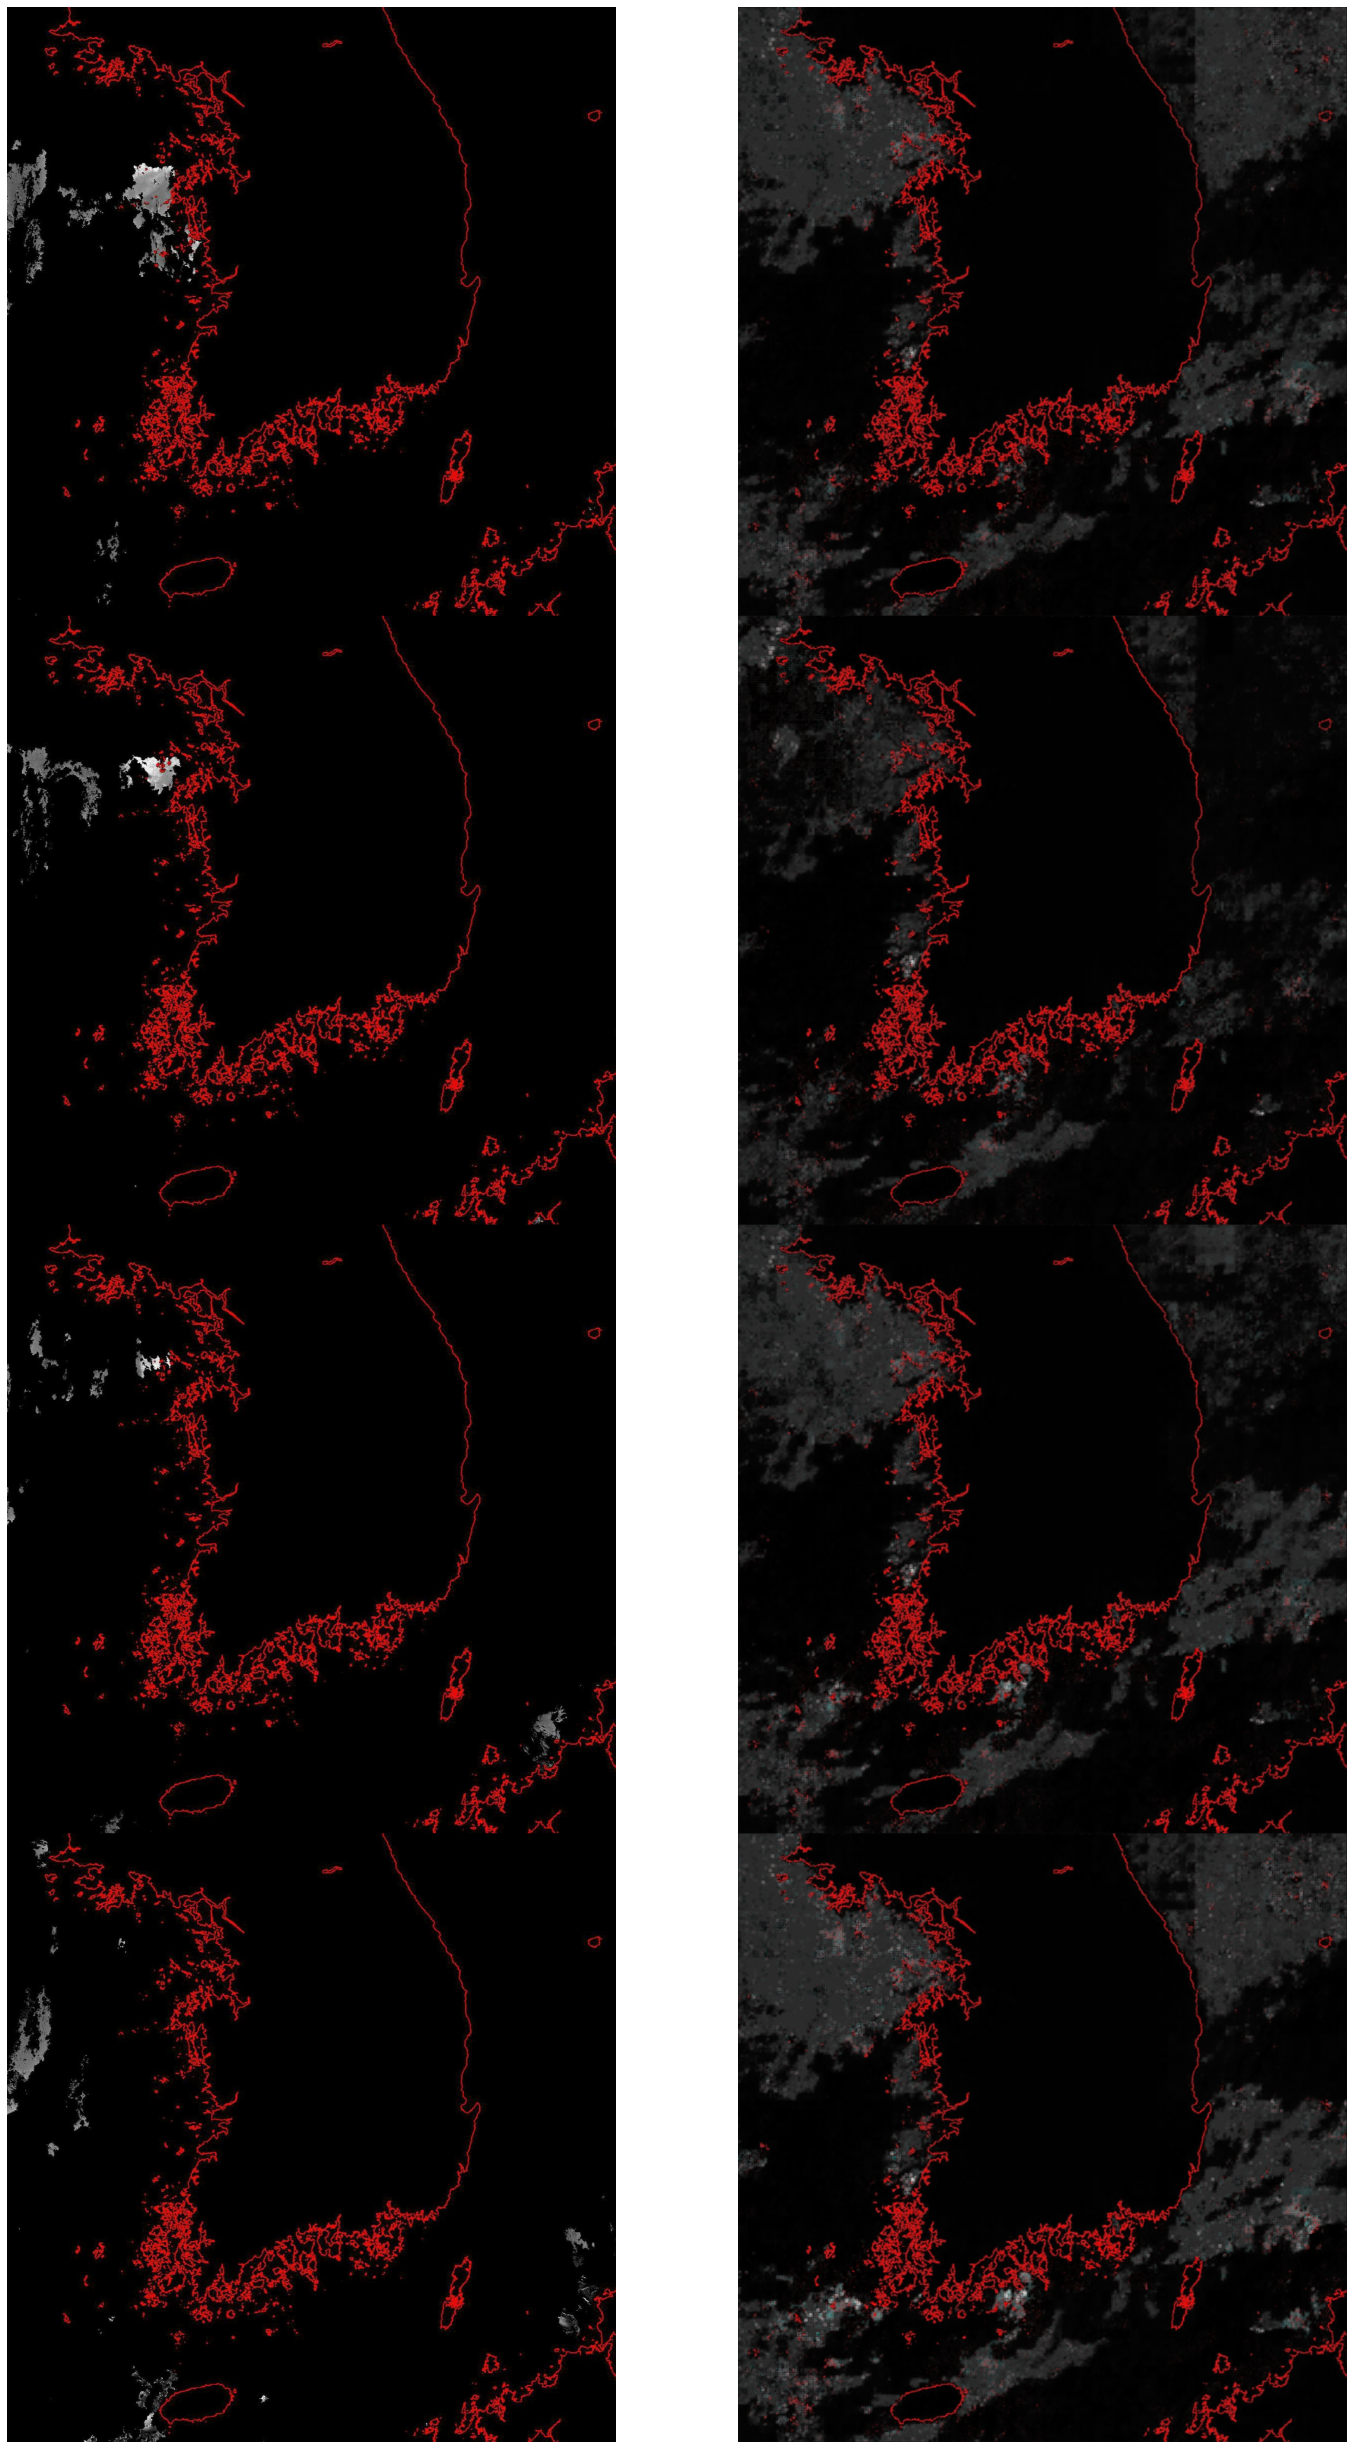

Reconstruction of a batch of test set images.


<Figure size 432x288 with 0 Axes>

In [172]:

"""
Reconstructs and plots a bacth of test images.
"""

inputs = next(batch_gen)
images=inputs[0]
_, _, pred_img= model(inputs[0], inputs[1])

#pred_img=(pred_img-np.min(pred_img))/(np.max(pred_img)-np.min(pred_img))

#print(test_data[''])

f = plt.figure(figsize=(24,60))
ax = f.add_subplot(1,2,1)
ax.imshow(convert_batch_to_image_grid(images))
plt.axis('off')

ax = f.add_subplot(1,2,2)
ax.imshow(convert_batch_to_image_grid(pred_img.numpy()))
plt.axis('off')


save_path = False
if save_path :
    plt.savefig(save_path + "reconstruction.png")

plt.show()
plt.clf()

print("Reconstruction of a batch of test set images.")

In [111]:
print(np.max(pred_img), np.min(pred_img))
pred_img=(pred_img-np.min(pred_img))/(np.max(pred_img)-np.min(pred_img))
print(np.max(pred_img), np.min(pred_img))

1.2986413 -0.23874827
1.0 0.0


In [9]:
print([x.split('/')[-1] for x in paths])

NameError: name 'paths' is not defined

In [ ]:
images, labels, paths = next(batch_gen)
_, _, pred_img= model(images, labels)

#print(test_data[''])

f = plt.figure(figsize=(24,60))
ax = f.add_subplot(1,2,1)
ax.imshow(convert_batch_to_image_grid(images))
plt.axis('off')

ax = f.add_subplot(1,2,2)
ax.imshow(convert_batch_to_image_grid(pred_img.numpy()))
plt.axis('off')


save_path = False
if save_path :
    plt.savefig(save_path + "reconstruction.png")

plt.show()
plt.clf()

print("Reconstruction of a batch of test set images.")

In [ ]:
print([x.split('/')[-1] for x in paths])